## Assignment 2 Deep Learning - CNNs

_Magnus Caesar_

In [1]:
import numpy as np
import torch
import torch.utils.data as data
from load_func import load_mnist_func
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
np.random.seed(42)

### General functions

Below are some useful functions and commands that aren't specific to any one exercise.
1. Loading the data
2. Reformating the data to fit PyTorch
3. compute_loss()
4. train()
5. plot_confusion()

In [2]:
# Load the data
# Inputs "station" vs "laptop" specifies the current machine
X_train, Y_train, X_test, Y_test = load_mnist_func("laptop")

Reading MNIST: laptop
In first loop label 0
In first loop label 1
In first loop label 2
In first loop label 3
In first loop label 4
In first loop label 5
In first loop label 6
In first loop label 7
In first loop label 8
In first loop label 9


In [3]:
# Loading the data into pytorch's domain
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Create TensorDataset for sequential data (ex 1)...
train_dataset = data.TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, Y_test_tensor)

# ... and for graphic data (ex 2-6)
train_dataset_cnn = data.TensorDataset(X_train_tensor.view(60000, 1, 28, 28), Y_train_tensor)
test_dataset_cnn = data.TensorDataset(X_test_tensor.view(10000, 1, 28, 28), Y_test_tensor)

**compute_loss()**

This is similar to the "compute_loss" function used in lab 2.

In [4]:
def compute_loss(y_pred_1h, input_data, labels):
    """
    y_pred: model(input)
    input_data: input from batch
    labels: labels from batch
    """

    loss = torch.nn.functional.cross_entropy(y_pred_1h, labels)
    acc = (y_pred_1h.argmax(dim=1) == labels.argmax(dim=1)).float().mean() # Check accuracy

    return loss, acc

**train() - for optimizing and getting statistics**

The following function "train" is used for all exercises in the assignment. It not only trains the model but also returns several statistics that can be used for plotting. 

In [5]:
def train(model, traindata, testdata, num_epochs=40, batch_size=100, alpha_lr=0.005, optmzr="sgd", reglz=0):
    """
    Train model.
    Input
        model:              a subclass of torch.nn.Module to be trained
        traindata:          self-explanatory. Must be of type torch.TensorDataset
        testdata:           see above
        num_epochs:         # epochs trained [int]
        batch_size:         # batches [int]
        optmzr:             optimizer. Select 'sgd' or 'adam' [string]
    Returns
        x_axis_train:       torch.arange(correct size)
        x_axis_test:        torch.arange(test size)
        train_costs:        [size 60000 / batches * num_epochs]
        train_accuracies:   [size 60000 / batches * num_epochs]
        test_costs:         [size num_epochs]. Average test cost every epoch
        test_accuracies:    [size num_epochs]. Also average across epoch
        total_time:         Time spent training the network
        avgspeed:           Average time / epoch
    Ex. 
    x_tr, x_te, trc, tra, tec, tac, time, avgspeed = train(model, train_dataset_cnn, test_dataset_cnn)
    """
    eval_k = 20
    
    # Optimizer
    if optmzr == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=alpha_lr, momentum=0)
    
    if optmzr == "adam":
        if reglz: # L2 regularization for Adam optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=alpha_lr, weight_decay=1e-5) # Standard parameters in Adam
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=alpha_lr) # Standard parameters in Adam

    # Load data
    train_loader = data.DataLoader(traindata, batch_size=batch_size, shuffle=True)
    #test_loader = data.DataLoader(testdata, batch_size=batch_size, shuffle=True)
    
    subset_indices = torch.randperm(len(testdata))[:1000]
    test_subset = data.Subset(testdata, subset_indices)
    test_loader = data.DataLoader(test_subset, batch_size=batch_size, shuffle=True)
    
    # Lists for later plotting
    train_costs = []
    train_accuracies = []
    test_costs = []
    test_accuracies = []

    test_iteration_list = []

    # For time tracking
    starttime = time.time()

    print("Initializing training")
    i = 0
    # Same training structure as from lab 2
    for epoch in range(0, num_epochs):
        model.train()

        # Training
        for input_data, labels in train_loader:
            i +=1
            # b[0][0][0] är en bild. Ser bra ut: kan plottas

            # print(b[0].size())
            # "plt.imshow(b[0][0][0])"

            # Training
            y_pred_1h = model(input_data) # Remade the computeloss function in a momentary lapse of reason
            optimizer.zero_grad()
            loss, train_acc = compute_loss(y_pred_1h, input_data, labels)
            loss.backward()
            optimizer.step()

            # Appending training metrics every iteration
            train_costs.append(loss.item())
            train_accuracies.append(train_acc)
        
        # Testing every eval_k'th iteration
            if i % eval_k == 0:
                t1 = []
                t2 = []
                for input_data, labels in test_loader:
                    y_pred_test = model(input_data)
                    loss, acc = compute_loss(y_pred_test, input_data, labels)
                    t1.append(loss.item())
                    t2.append(acc)
                test_costs.append(np.mean(t1))
                test_accuracies.append(np.mean(t2))
                test_iteration_list.append(i)

        # Time related
        t0 = time.time()
        t_tot = t0-starttime
        avgspeed = t_tot / (epoch+1)
        est_time_remaining = (avgspeed) * (num_epochs - epoch+1)

        # Statistics
        print(f"Epoch {epoch+1} / {num_epochs}:")
        print(f"Current testing loss:      {np.mean(test_costs[-1]):>10.4f}")
        print(f"Current test accuracy:     {np.mean(test_accuracies[-1]):>10.2f}")
        print(f"Ellapsed time:             {round(t0 - starttime, 2):>10.2f} seconds.")
        print(f"Estimated time remaining:  {round(est_time_remaining, 2):>10.2f} seconds.")
        print()
    
    # Time related
    t_end = time.time()
    total_time = t_end-starttime
    print(f"Final results:")
    print(f"Total time elapsed: {round(total_time, 3)} s")
    print(f"Average speed: {round(avgspeed, 3)} s / epoch")

    # x-axis for plotting
    x_axis_train = torch.arange(len(train_costs)) # For every actual iteration
    x_axis_test = torch.arange(len(test_costs)) # Average for every epoch

    return x_axis_train, test_iteration_list, train_costs, train_accuracies, test_costs, test_accuracies, total_time, avgspeed

**plot_confusion() - more statistics after a model is done training**

In [6]:
def plot_confusion(model, testdata):
    """
    Plot a confusion matrix given a trained model and testdata.
    Inputs
        model: model to predict classes. Should be trained
        testdata: of type TensorDataset (to allow for both sequential and graphic data for CNNs)
    """

    test_loader = data.DataLoader(testdata, batch_size=200) # Get testdata
    
    y_pred = []
    y_true = []

    for input_data, labels in test_loader: 
        # Comes in batches
        output = model(input_data)

        y_pred += output.argmax(dim=1).flatten()
        y_true += labels.argmax(dim=1).flatten()

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")


In [ ]:
# Plot function
def single_plot(e, alpha=0.001, batch_size=64):
    """e = the model trained"""

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sub = f'| Batch size: {batch_size} | Learning rate: {alpha} | Training time: {round(float(e[-2]), 3)} seconds.'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=10)

    # Standard learning rate for SGD, although I didn't declare it anywhere
    fig.suptitle("Training vs testing accuracy", y=1.1)

    axs[0].plot(e[0][::100], e[3][::100], label=f"Training: final accuracy = {round(float(np.mean(e[3][::-10])), 3)}")
    axs[0].plot(e[1], e[5], label=f"Testing: final accuracy = {round(float(e[5][-1]), 3)}")
    axs[0].legend()
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_title("Accuracy")

    axs[1].plot(e[0][::100], e[2][::100], label=f"Training: final cost = {round(e[2][-1], 3)}")
    axs[1].plot(e[1], e[4], label=f"Testing: final cost = {round(e[4][-1], 3)}")
    axs[1].legend()
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Cost")
    axs[1].set_title("Cost")

### Exercise 1. Multi-layer fully connected neural network
Implement exactly the same network as for assignment 1.

1. Compare the performance
2. Compare speed
3. Learning curve plot

**Sequential network class**

The first network from assignment 1 is a linear model. The input dimension is 784 (28x28 pixels) and the output dimension is 10. The second network is multilayered. The one I implemented had 2 hidden layers á 100 neurons each, which the same necessary input and output dimensions.

In [ ]:
class SeqNetwork(torch.nn.Module):
    def __init__(self, num_hidden_layers, input_dim=784, output_dim=10, hidden_dim=100):
        super().__init__()
        self.layers = torch.nn.ModuleList([]) # Ska ha lista med lager / moduler

        # If no hidden layers
        if num_hidden_layers == 0: 
            self.layers.append(torch.nn.Linear(input_dim, output_dim, dtype=torch.float32))

        else:
            # First hidden layer (if num_hidden_layers = 1)
            self.layers.append(torch.nn.Linear(input_dim, hidden_dim))
            self.layers.append(torch.nn.ReLU())
            
            # Add extra layers if more than >1
            for _ in range(1, num_hidden_layers):
                self.layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
                self.layers.append(torch.nn.ReLU())
            
            self.layers.append(torch.nn.Linear(hidden_dim, output_dim))
        

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x
        

In [115]:
seq_model = SeqNetwork(0)

batch_size = 100 # size used in lab1
num_iterations = 1000 # as from assignment 1
# 1 epoch is 600 iterations
# 10 epochs are 6000 iterations
num_epochs = 10

seq_stats = train(seq_model, train_dataset, test_dataset, num_epochs=num_epochs, batch_size=batch_size)

Initializing training
Epoch 1 / 10:
Current testing loss:          1.0051
Current test accuracy:           0.82
Ellapsed time:                   2.45 seconds.
Estimated time remaining:       26.99 seconds.

Epoch 2 / 10:
Current testing loss:          0.7449
Current test accuracy:           0.86
Ellapsed time:                   4.58 seconds.
Estimated time remaining:       22.90 seconds.

Epoch 3 / 10:
Current testing loss:          0.6359
Current test accuracy:           0.88
Ellapsed time:                   6.84 seconds.
Estimated time remaining:       20.53 seconds.

Epoch 4 / 10:
Current testing loss:          0.5738
Current test accuracy:           0.89
Ellapsed time:                   8.93 seconds.
Estimated time remaining:       17.87 seconds.

Epoch 5 / 10:
Current testing loss:          0.5335
Current test accuracy:           0.89
Ellapsed time:                  11.16 seconds.
Estimated time remaining:       15.62 seconds.

Epoch 6 / 10:
Current testing loss:          0.5040
C

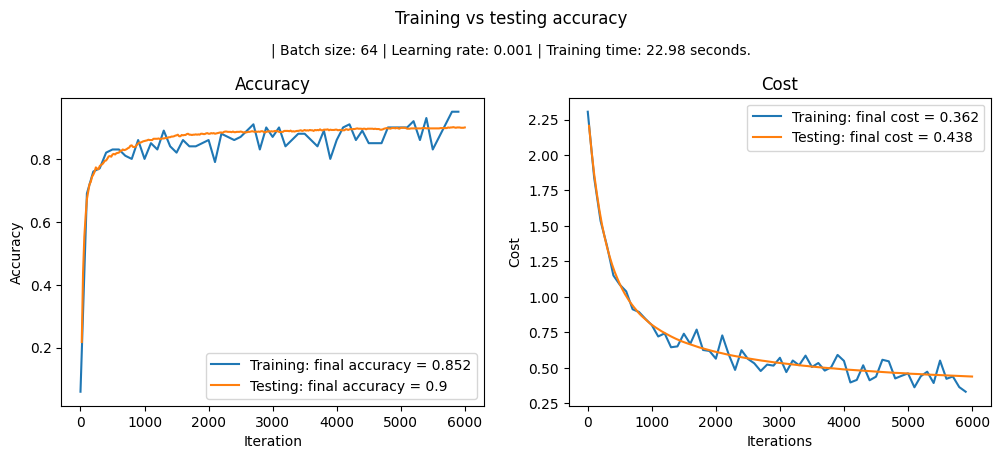

In [116]:
single_plot(seq_stats)

### Exercise 2. Multilayer convolutional neural network
CNN using PyTorch with SGD and cross-entropy loss. Reach 98% accuracy.

1. How many learnable weights does the network contain? Compare with previous exercise.
2. Learning curve plot.

**Base class CNN**

In [117]:
class ConvNetwork(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, stride=2)
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        #relu
        #pool
        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        #relu
        self.flatten = torch.nn.Flatten()
        self.fullyconnected = torch.nn.Linear(32*7*7, 10)
        #self.softm = torch.nn.Softmax(dim=1)

        self.components = torch.nn.ModuleList([self.conv1,
                                               self.relu,
                                               self.pool,
                                               self.conv2,
                                               self.relu,
                                               self.pool,
                                               self.conv3,
                                               self.relu,
                                               self.flatten,
                                               self.fullyconnected])
    
    def forward(self, x):

        for l in self.components:
            x = l(x)

        return x

**Optimizing and training**

In [118]:
model = ConvNetwork()

num_epochs = 10
batch_size = 64 # size used in lab1

ex2 = train(model, train_dataset_cnn, test_dataset_cnn, num_epochs=num_epochs, batch_size=batch_size)

Initializing training
Epoch 1 / 10:
Current testing loss:          0.5913
Current test accuracy:           0.83
Ellapsed time:                  21.23 seconds.
Estimated time remaining:      233.54 seconds.

Epoch 2 / 10:
Current testing loss:          0.3508
Current test accuracy:           0.90
Ellapsed time:                  38.81 seconds.
Estimated time remaining:      194.05 seconds.

Epoch 3 / 10:
Current testing loss:          0.2774
Current test accuracy:           0.92
Ellapsed time:                  57.11 seconds.
Estimated time remaining:      171.33 seconds.

Epoch 4 / 10:
Current testing loss:          0.2129
Current test accuracy:           0.94
Ellapsed time:                  75.39 seconds.
Estimated time remaining:      150.79 seconds.

Epoch 5 / 10:
Current testing loss:          0.1809
Current test accuracy:           0.94
Ellapsed time:                  93.82 seconds.
Estimated time remaining:      131.35 seconds.

Epoch 6 / 10:
Current testing loss:          0.1608
C

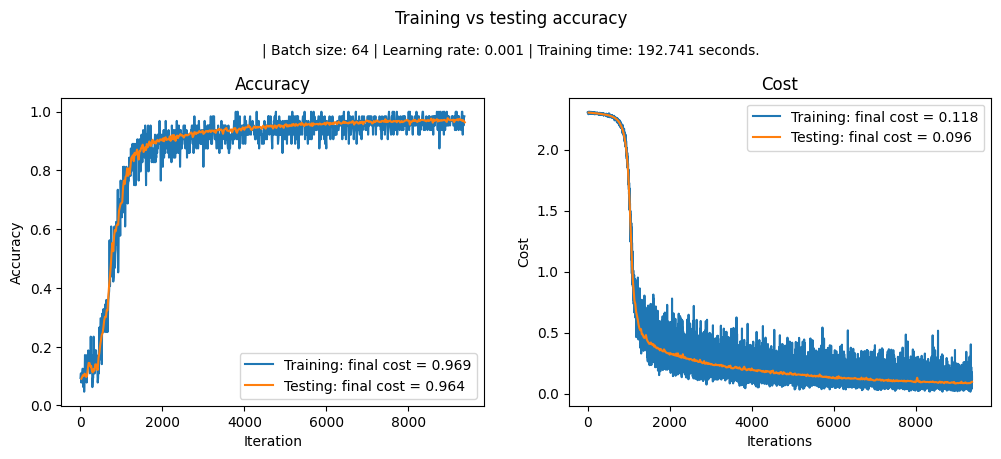

In [ ]:
single_plot(ex2, 0.001)

### Exercise 3: swapping the order of max pooling and the activation function

1. How does this affect the models performance? Final accuracy?
2. Swapping ReLU to tanh: differences? Time taken, final accuarcy?

In [10]:
class SwapedConvNetwork(torch.nn.Module):
    # Easier to create a new class than to fiddle in the old one
    def __init__(self, activator: str):
        super().__init__()

        # Reused layers
        if activator.lower() == "relu":
            self.activator = torch.nn.ReLU()
        if activator.lower() == "tanh":
            self.activator = torch.nn.Tanh()
        
        self.pool = torch.nn.MaxPool2d(2, stride=2)

        # Full laid out structure
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        # Pool
        # Activator
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        # Pool
        # Activator
        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Activator
        self.flatten = torch.nn.Flatten()
        self.fullyconnected = torch.nn.Linear(32*7*7, 10)
        #self.softm = torch.nn.Softmax(dim=1)

        self.components = torch.nn.ModuleList([self.conv1,
                                               self.pool,
                                               self.activator,
                                               self.conv2,
                                               self.pool,
                                               self.activator,
                                               self.conv3,
                                               self.activator,
                                               self.flatten,
                                               self.fullyconnected])
    
    def forward(self, x):

        for l in self.components:
            x = l(x)

        return x



In [12]:
model = SwapedConvNetwork("relu")
model_ex32 = SwapedConvNetwork("tanh")

ex3 = train(model, train_dataset_cnn, test_dataset_cnn, num_epochs=10, batch_size=64, optmzr="sgd")
ex32 = train(model_ex32, train_dataset_cnn, test_dataset_cnn, num_epochs=10, batch_size=64, optmzr="sgd")


Initializing training
Epoch 1 / 10:
Current testing loss:          0.6480
Current test accuracy:           0.83
Ellapsed time:                  19.58 seconds.
Estimated time remaining:      215.41 seconds.

Epoch 2 / 10:
Current testing loss:          0.3314
Current test accuracy:           0.91
Ellapsed time:                  36.41 seconds.
Estimated time remaining:      182.05 seconds.

Epoch 3 / 10:
Current testing loss:          0.2840
Current test accuracy:           0.92
Ellapsed time:                  54.72 seconds.
Estimated time remaining:      164.16 seconds.

Epoch 4 / 10:
Current testing loss:          0.2119
Current test accuracy:           0.94
Ellapsed time:                  72.32 seconds.
Estimated time remaining:      144.64 seconds.

Epoch 5 / 10:
Current testing loss:          0.1752
Current test accuracy:           0.95
Ellapsed time:                  90.26 seconds.
Estimated time remaining:      126.36 seconds.

Epoch 6 / 10:
Current testing loss:          0.1441
C

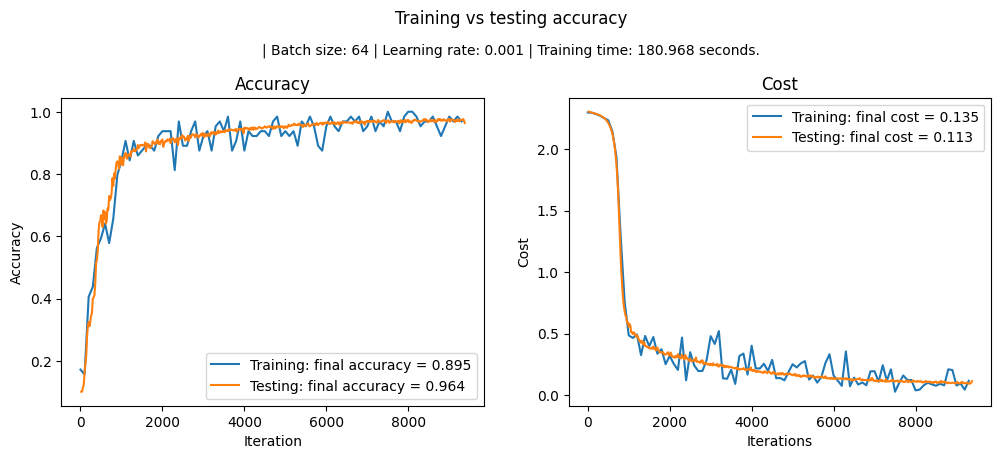

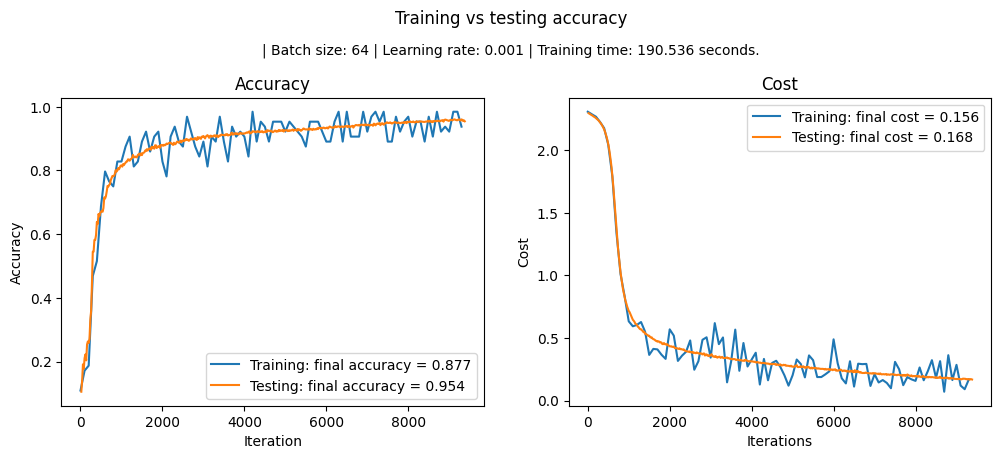

In [20]:
single_plot(ex3)
single_plot(ex32)

In [121]:
model_ex32 = SwapedConvNetwork("tanh")
ex32 = train(model_ex32, train_dataset_cnn, test_dataset_cnn, num_epochs=10, batch_size=64)


Initializing training
Epoch 1 / 10:
Current testing loss:          0.8846
Current test accuracy:           0.81
Ellapsed time:                  17.59 seconds.
Estimated time remaining:      193.52 seconds.

Epoch 2 / 10:
Current testing loss:          0.4133
Current test accuracy:           0.89
Ellapsed time:                  36.27 seconds.
Estimated time remaining:      181.35 seconds.

Epoch 3 / 10:
Current testing loss:          0.3275
Current test accuracy:           0.91
Ellapsed time:                  55.20 seconds.
Estimated time remaining:      165.59 seconds.

Epoch 4 / 10:
Current testing loss:          0.2807
Current test accuracy:           0.93
Ellapsed time:                  74.12 seconds.
Estimated time remaining:      148.24 seconds.

Epoch 5 / 10:
Current testing loss:          0.2476
Current test accuracy:           0.93
Ellapsed time:                  94.03 seconds.
Estimated time remaining:      131.64 seconds.

Epoch 6 / 10:
Current testing loss:          0.2226
C

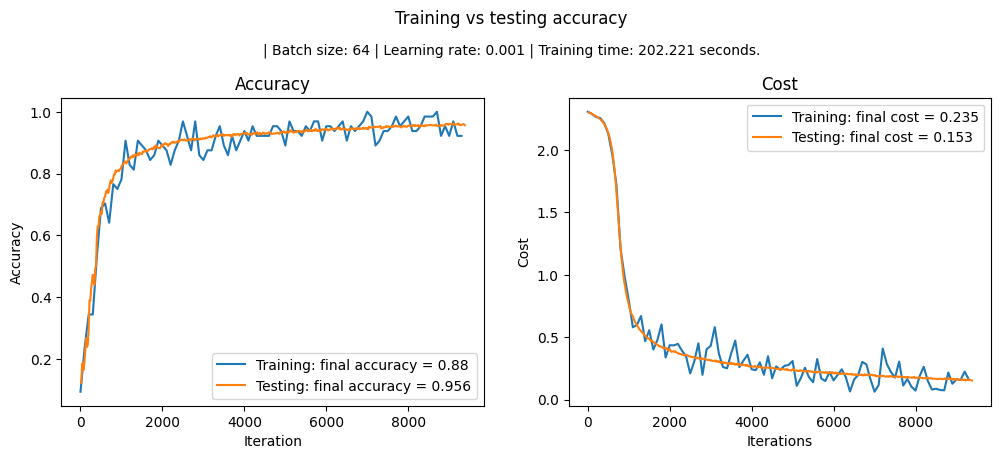

In [122]:
single_plot(ex32, 0.001)

### Exercise 4: swapping SGD for ADAM

Are good results obtained faster? Compare with SGD; provide learning curve plot.

In [22]:
model_ex4_sgd = SwapedConvNetwork("relu")
model_ex4_adam = SwapedConvNetwork("relu")

num_epochs = 10

sgd_stats = train(model_ex4_sgd, train_dataset_cnn, test_dataset_cnn, num_epochs=num_epochs, optmzr="sgd")
adam_stats = train(model_ex4_adam, train_dataset_cnn, test_dataset_cnn, num_epochs=num_epochs, optmzr="adam")

Initializing training
Epoch 1 / 10:
Current testing loss:          2.2462
Current test accuracy:           0.53
Ellapsed time:                  15.19 seconds.
Estimated time remaining:      167.04 seconds.

Epoch 2 / 10:
Current testing loss:          0.5358
Current test accuracy:           0.84
Ellapsed time:                  30.54 seconds.
Estimated time remaining:      152.70 seconds.

Epoch 3 / 10:
Current testing loss:          0.3646
Current test accuracy:           0.90
Ellapsed time:                  45.79 seconds.
Estimated time remaining:      137.37 seconds.

Epoch 4 / 10:
Current testing loss:          0.3133
Current test accuracy:           0.91
Ellapsed time:                  61.25 seconds.
Estimated time remaining:      122.50 seconds.

Epoch 5 / 10:
Current testing loss:          0.2760
Current test accuracy:           0.93
Ellapsed time:                  76.12 seconds.
Estimated time remaining:      106.57 seconds.

Epoch 6 / 10:
Current testing loss:          0.2517
C

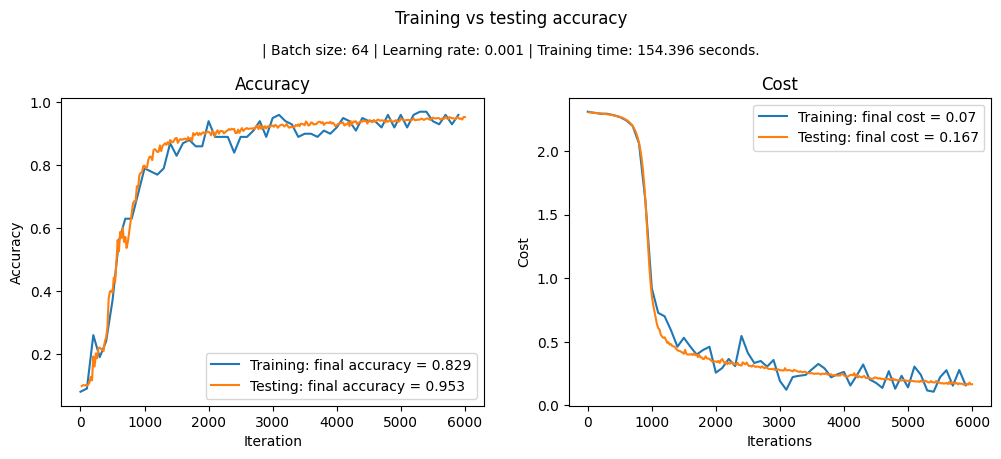

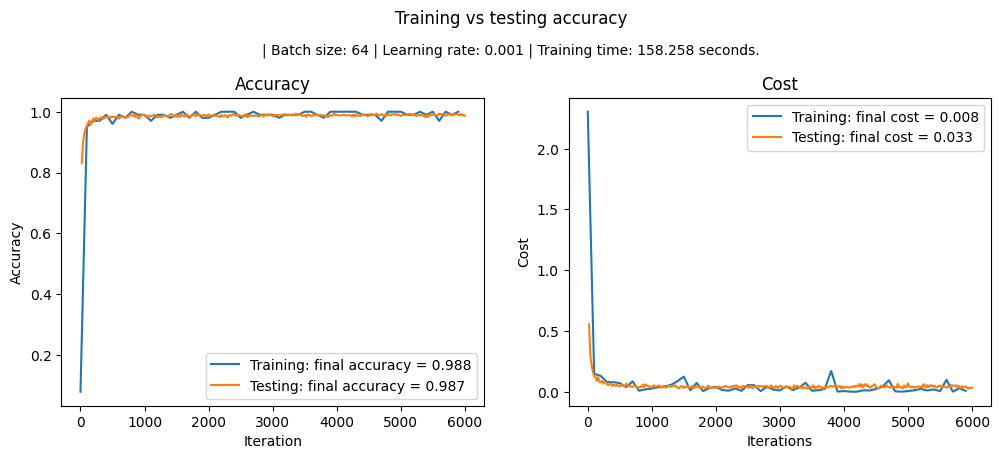

In [23]:
single_plot(sgd_stats)
single_plot(adam_stats)

### Exercise 5: residual connection

Does this improve performance?

Use the same structure as before but replace each conv+act pair with a block of two similar parts with a residual connection over each such block.

So x -> conv1 -> relu = f(x) ==> x -> conv1 -> relu -> conv1 -> relu = g(x) + x 

In [27]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.activator = torch.nn.ReLU()
        self.conv = torch.nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        identity = x  # Save input for residual connection
        out = self.conv(x)
        out = self.activator(out)
        out = self.conv(out)
        out = self.activator(out)
        torch.add(out, identity)
        #out += identity  # Add residual connection. GOOFY AHH CHATGPT DELUSION ! ! !   
        return out

class ResConvNetwork(torch.nn.Module):
    def __init__(self, activator: str):
        super().__init__()
        
        self.pool = torch.nn.MaxPool2d(2, stride=2)

        self.initial_conv = torch.nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.resblock1 = ResidualBlock(8) # blir det inte lite konstigt med dimensionerna här?
        
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.resblock2 = ResidualBlock(16)

        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.resblock3 = ResidualBlock(32)

        self.flatten = torch.nn.Flatten()
        self.fullyconnected = torch.nn.Linear(32*7*7, 10)

        self.components = torch.nn.ModuleList([self.initial_conv,
                                               self.resblock1,
                                               self.conv2,
                                               self.pool,
                                               self.resblock2,
                                               self.conv3,
                                               self.pool,
                                               self.resblock3,
                                               self.flatten,
                                               self.fullyconnected])
    
    def forward(self, x):
        for l in self.components:
            x = l(x)
        
        return x

In [28]:
resnet_model = ResConvNetwork("relu")

resnet_stats = train(resnet_model, train_dataset_cnn, test_dataset_cnn, num_epochs=5, batch_size=64, optmzr="adam")

Initializing training
Epoch 1 / 5:
Current testing loss:          0.0758
Current test accuracy:           0.98
Ellapsed time:                  63.69 seconds.
Estimated time remaining:      382.16 seconds.

Epoch 2 / 5:
Current testing loss:          0.0703
Current test accuracy:           0.98
Ellapsed time:                 129.01 seconds.
Estimated time remaining:      322.53 seconds.

Epoch 3 / 5:
Current testing loss:          0.1220
Current test accuracy:           0.96
Ellapsed time:                 194.47 seconds.
Estimated time remaining:      259.30 seconds.

Epoch 4 / 5:
Current testing loss:          0.0599
Current test accuracy:           0.98
Ellapsed time:                 261.16 seconds.
Estimated time remaining:      195.87 seconds.

Epoch 5 / 5:
Current testing loss:          0.0758
Current test accuracy:           0.98
Ellapsed time:                 328.45 seconds.
Estimated time remaining:      131.38 seconds.

Final results:
Total time elapsed: 328.452 s
Average speed

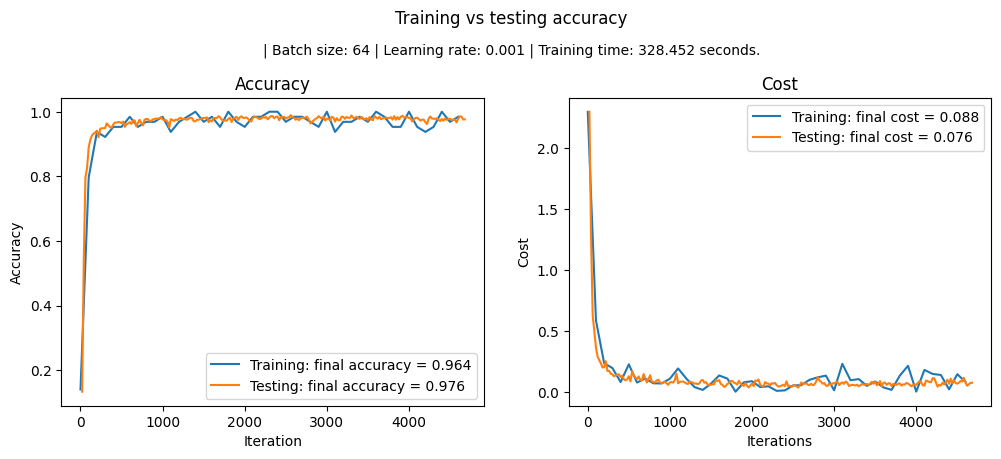

In [29]:
single_plot(resnet_stats)

### Exercise 6: CNN with three variations

Todo

1. Swapa SGD mot ADAM och se till att det funkar 
2. Implementera residual connection och kolla vad som sker
3. CNN with three variations:
    1. Regularization
    2. Hur olika djup påverkar träningshastigheten?
    3. Hur olika learning rates påverkar träningshastigheten?

Misc: på något vis få ut x-axel från train() så att man kan plotta flera samtidigt

In [40]:
standard_adam_cnn_relu = SwapedConvNetwork(activator="relu")  # Base network

standard_adam_cnn_tanh = SwapedConvNetwork(activator="tanh") # Compare Adam with ReLU vs Tanh
regularized_adam_cnn = SwapedConvNetwork(activator="relu") # Compare nonregularized vs regularized
higherlr_adam_cnn = SwapedConvNetwork(activator="relu") # Compare with a significantly higher learning rate

xtr = train_dataset_cnn
xte = test_dataset_cnn

net1 = train(standard_adam_cnn_relu, xtr, xte, num_epochs=10, batch_size=64, optmzr="adam")
net2 = train(standard_adam_cnn_tanh, xtr, xte, num_epochs=10, batch_size=64, optmzr="adam")
net3 = train(regularized_adam_cnn, xtr, xte, num_epochs=10, batch_size=64, optmzr="adam", reglz=1)
net4 = train(higherlr_adam_cnn, xtr, xte, num_epochs=10, batch_size=64, alpha_lr=0.02)

names = ["CNN ReLU", "CNN Tanh", "CNN ReLU with regularization", "CNN ReLU with higher LR"]

Initializing training
Epoch 1 / 10:
Current testing loss:          0.0594
Current test accuracy:           0.98
Ellapsed time:                  18.61 seconds.
Estimated time remaining:      204.75 seconds.

Epoch 2 / 10:
Current testing loss:          0.0520
Current test accuracy:           0.98
Ellapsed time:                  36.98 seconds.
Estimated time remaining:      184.90 seconds.

Epoch 3 / 10:
Current testing loss:          0.0509
Current test accuracy:           0.98
Ellapsed time:                  55.34 seconds.
Estimated time remaining:      166.01 seconds.

Epoch 4 / 10:
Current testing loss:          0.0359
Current test accuracy:           0.99
Ellapsed time:                  74.76 seconds.
Estimated time remaining:      149.52 seconds.

Epoch 5 / 10:
Current testing loss:          0.0419
Current test accuracy:           0.99
Ellapsed time:                  94.10 seconds.
Estimated time remaining:      131.74 seconds.

Epoch 6 / 10:
Current testing loss:          0.0462
C

Exercise 6e: find erroneous classifications

Text(0.5, 1.0, 'Cost')

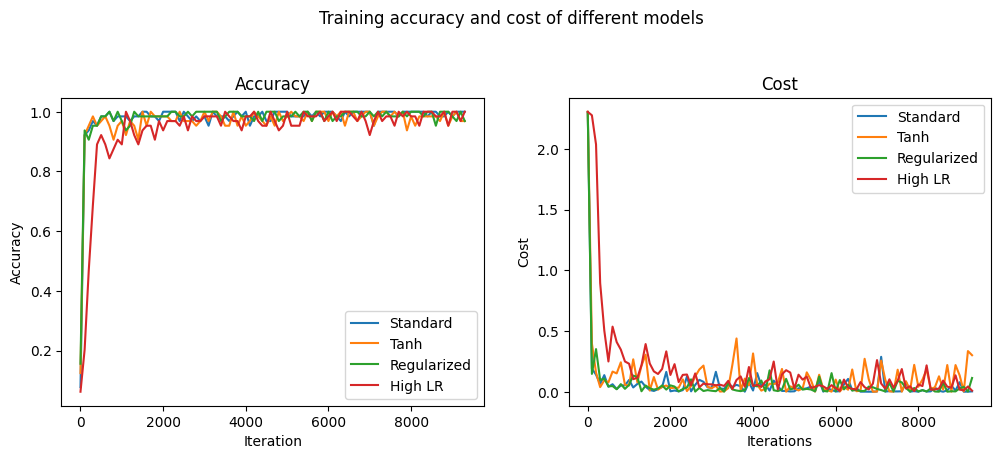

In [119]:
models = [net1, net2, net3, net4]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# sub = f'| Batch size: {batch_size} | Learning rate: {alpha} | Training time: {round(float(e[-2]), 3)} seconds.'
# fig.text(0.5, 0.99, sub, ha='center', fontsize=10)

# Standard learning rate for SGD, although I didn't declare it anywhere
fig.suptitle("Training accuracy and cost of different models", y=1.1)
names = ["Standard", "Tanh", "Regularized", "High LR"]
for i, m in enumerate(models):
    axs[0].plot(m[0][::100], m[3][::100], label=names[i])
    axs[1].plot(m[0][::100], m[2][::100], label=names[i])
axs[0].legend()
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Accuracy")

axs[1].legend()
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel("Cost")
axs[1].set_title("Cost")

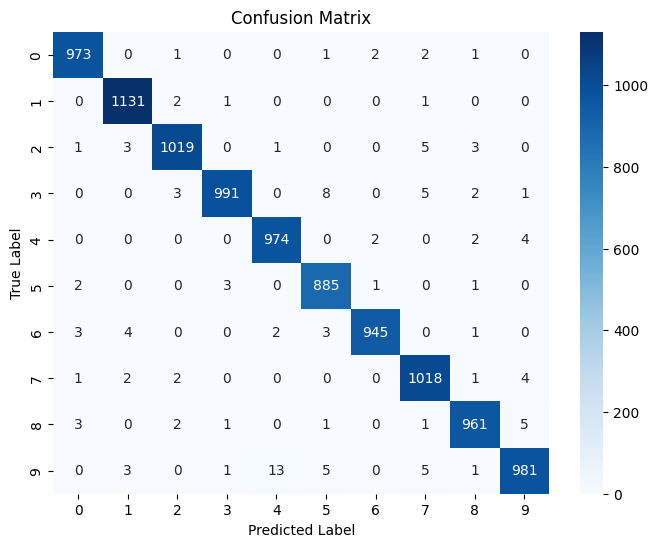

In [42]:
# Confusion
plot_confusion(regularized_adam_cnn, test_dataset_cnn)

In [104]:
#bestmodel = ConvNetwork()
#model_stats = train(bestmodel, train_dataset_cnn, test_dataset_cnn)

bestmodel = regularized_adam_cnn

test_loader = data.DataLoader(test_dataset_cnn, batch_size=1)
misclasses = []
labels = []
preds = []
for inp, lab in test_loader:
    y_pred = bestmodel(inp)
    if y_pred.argmax(dim=1) != lab.argmax(dim=1):
        misclasses.append(inp.view(28, 28))
        labels.append(lab.argmax(dim=1))
        preds.append(y_pred.argmax(dim=1))

(122, 28, 28)
(122,)
torch.Size([1, 10])
0
1
2
3
4
0
1
2
3
4


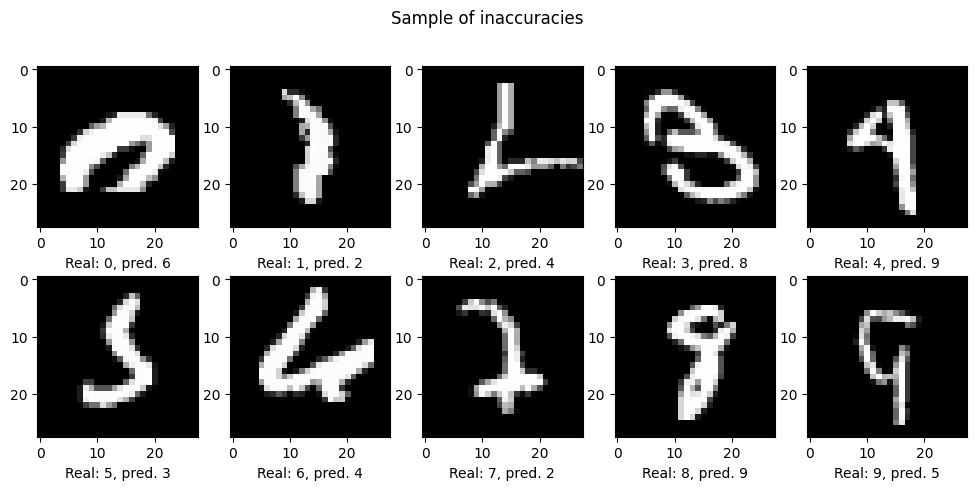

In [112]:
imgs = misclasses
labels = [int(i) for i in labels]
preds = [int(i) for i in preds]

print(np.shape(imgs))
print(np.shape(labels))
print(np.shape(y_pred))

#plt.imshow(imgs[1], cmap="gray")
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Sample of inaccuracies")

infig = []
for i, im in enumerate(imgs):
    # calm thoughts. stay calm. why did i make it this way lmfao
    label = labels[i]
    if label not in infig: #if not alrady plotted
        i1 = 0 if label in [0,1,2,3,4] else 1 # 0 ->
        i2 = label%5
        print(i2)
        axs[i1, i2].imshow(im, cmap="gray")
        infig.append(label)

        axs[i1, i2].set_xlabel(f"Real: {label}, pred. {preds[i]}")



    

